# Topic modeling

Yiting (Elle) Tsai (yt9mh@virginia.edu)<br>
DS 5001<br>
28 April 2020<br>

## Overview
1.  Aim to find the topics for the documents to see if there is different topics about COVID-19

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

In [5]:
import nltk
from nltk.corpus import stopwords 

In [14]:
OHCO = ['doc_id']

In [6]:
df = pd.read_csv('covid19_news.csv')
df['doc_date'] = pd.to_datetime(df['doc_date'])
df.head()

,doc_content,doc_date,doc_id,doc_source,doc_title,doc_url,doc_lemma
0,By YANAN WANG and MIKE STOBBE\nBEIJING (AP) — ...,2020-01-08,983556,US News,Chinese Report Says Illnesses May Be From New ...,https://www.usnews.com/news/world/articles/202...,yanan wang mike stobbe beijing ( ap ) — prelim...
1,BEIJING (AP) — Health authorities in a central...,2020-01-10,985558,US News,China Reports 1st Death From New Type of Coron...,https://www.usnews.com/news/health-news/articl...,beijing ( ap ) — health authority central chin...
2,Here are some of the latest health and medical...,2020-01-13,987316,US News,"Health Highlights: Jan. 13, 2020",https://www.usnews.com/news/health-news/articl...,"late health medical news development , compile..."
3,Here are some of the latest health and medical...,2020-01-14,988361,US News,"Health Highlights: Jan. 14, 2020",https://www.usnews.com/news/health-news/articl...,"late health medical news development , compile..."
4,"By MARI YAMAGUCHI, Associated Press\nTOKYO (AP...",2020-01-16,989997,US News,Patient in Japan Confirmed as Having New Virus...,https://www.usnews.com/news/world/articles/202...,"mari yamaguchi , associate press tokyo ( ap ) ..."


## Latent Dirichlet Allocation (LDA)

In [7]:
stop_words = set(stopwords.words('english')) 
tokenizer = nltk.RegexpTokenizer(r"\w+") # remove punctuation

df['tokenize'] = 0

for i in range(len(df)):
    rm_words = tokenizer.tokenize(df['doc_lemma'][i].lower()) 
    df['tokenize'][i] = [w for w in rm_words if not w in stop_words] 



In [8]:
tfv = CountVectorizer(stop_words='english')
tf = tfv.fit_transform(df['doc_lemma'])
TERMS = tfv.get_feature_names()

In [9]:
lda = LDA(n_components=5, max_iter=600, learning_offset=50., random_state=0)

### Theta

In [10]:
THETA = pd.DataFrame(lda.fit_transform(tf), index= df['doc_id'])
THETA.columns.name = 'topic_id'

In [15]:
THETA.sample(10).style.background_gradient()

topic_id,0,1,2,3,4
doc_id,,,,,
1035632,0.000664066,0.000645346,0.0349882,0.963051,0.000651883
1037427,0.0178945,0.405656,0.115079,0.461019,0.000351392
1031451,0.00203523,0.87146,0.122439,0.00203648,0.00202915
994493,0.00082365,0.480572,0.000814114,0.133131,0.38466
1036269,0.859484,0.000326626,0.0897494,0.0501148,0.000325154
1035412,0.00111178,0.00110283,0.506437,0.490259,0.00109032
1033801,0.816456,0.000393549,0.00040336,0.182353,0.000393648
1039638,0.336609,0.0013634,0.00136462,0.598338,0.0623255
1007257,0.17581,0.760376,0.00065558,0.0128889,0.0502692


### Phi

In [12]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'
PHI.T.sample(5).style.background_gradient()

topic_id,0,1,2,3,4
term_str,,,,,
torment,2.49451,0.201024,0.20159,0.200597,2.90228
marmara,0.2,0.201498,0.2,0.200418,1.19808
packaged,0.20113,0.201943,0.2,2.19693,0.2
clicked,1.18916,0.2,0.206014,0.2,0.204827
aisle,28.5021,0.200925,0.202845,0.202737,8.89139


## Inspect Result
### Get Top Terms per Topic

In [12]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x), 1)
TOPICS.head()

term_str,0,1,2,3,4,5,6,7,8,9,label
topic_id,,,,,,,,,,,
0,say,trump,coronavirus,president,people,american,house,make,government,need,0 say trump coronavirus president people ameri...
1,say,china,case,coronavirus,virus,people,reuters,country,health,new,1 say china case coronavirus virus people reut...
2,say,game,event,march,coronavirus,biden,election,team,postpone,cancel,2 say game event march coronavirus biden elect...
3,say,state,people,health,test,new,coronavirus,virus,case,associate,3 say state people health test new coronavirus...
4,coronavirus,china,virus,news,disease,chinese,spread,report,cdc,wuhan,4 coronavirus china virus news disease chinese...


### Sort Topics by Doc Weight

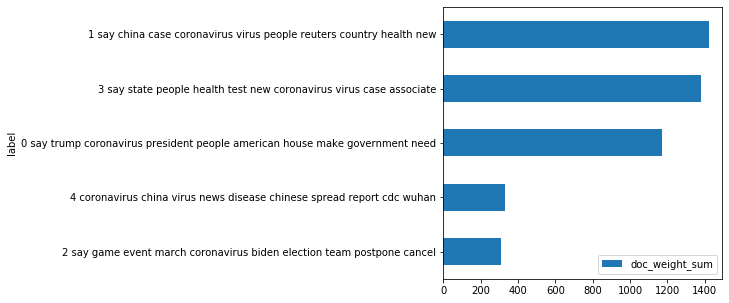

In [15]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,5)) ;

From the five topics, we can see that topic 0 is more about the government and politics, which may include many articles that wrote Trump or government announcements. Topic 1 and topic 3 indicates more about people's health prospective, which includes the how coronavirus case change and the testing result. Topic 2 are related to election and the cause that coronavirus have made to the society, such as many events being postponed and canceled. Topic 4 are news articles more focused on reporting coronavirus associated with Wuhan, China.

Since there are some topics delivering overlapping messages, the potential topics may be less than 5.

## Explore Topics by Doc Source

In [21]:
topic_cols = [t for t in range(5)]
source = THETA.join(df.set_index('doc_id'), on='doc_id')\
    .reset_index().set_index(['doc_source']+OHCO)\
    .groupby('doc_source')[topic_cols].mean()\
    .T                                            
source.index.name = 'topic_id'

In [23]:
source['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x),1)
AUTHORS.sort_values('Breibart', ascending=False).style.background_gradient()

NameError: name 'TOPICS' is not defined

## LDA Viz

In [8]:
from gensim import corpora
dictionary = corpora.Dictionary(df['tokenize'])
corpus = [dictionary.doc2bow(text) for text in df['tokenize']]


In [15]:
import gensim
NUM_TOPICS = 3 # reduce topics to 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.016*"say" + 0.013*"china" + 0.013*"coronavirus" + 0.011*"case"')
(1, '0.011*"say" + 0.010*"trump" + 0.008*"coronavirus" + 0.006*"president"')
(2, '0.024*"say" + 0.014*"state" + 0.012*"people" + 0.011*"health"')


We can clearly see that if we cluster new articles in three topics, those three topics have clear different perspectives. Topic 0 represents news articles associated with China. Topic 1 represents news articles related to Trump's policy for COVID-19 and topic 2 is related to people's health.


In [16]:
new_doc = ['trump', 'suggest', 'injection', 'disinfect', 'beat', 'coronavirus']
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(ldamodel.get_document_topics(new_doc_bow))

[(59, 1), (277, 1), (1356, 1), (2365, 1), (4132, 1), (7249, 1)]
[(0, 0.0608163), (1, 0.87225646), (2, 0.06692727)]


In [17]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)